# Dogbreed

$\textbf{Data Source}$: 
Kaggle Dog Breed Identification Competition https://www.kaggle.com/c/dog-breed-identification

$\textbf{Data Preparation}$:
To run this Jupyter Notebook, download data from Kaggle Website and unzip image folders 'train.zip' and 'test.zip'. Then place resulting folders 'train' and 'test' along with the 'labels.csv' file into the 'Dogbreed' directory of your cloned version of the NeuralNetworkLibrary repository.

$\textbf{Objective}$:
Image Classification - All images are of dogs, goal is to identify the dog breed for each image out of 120 different breeds present in the data.

In [1]:
# Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Imports
import sys
sys.path.append("../")
from Applications.Vision import *

### Look at the Data

First let's look at the images. 

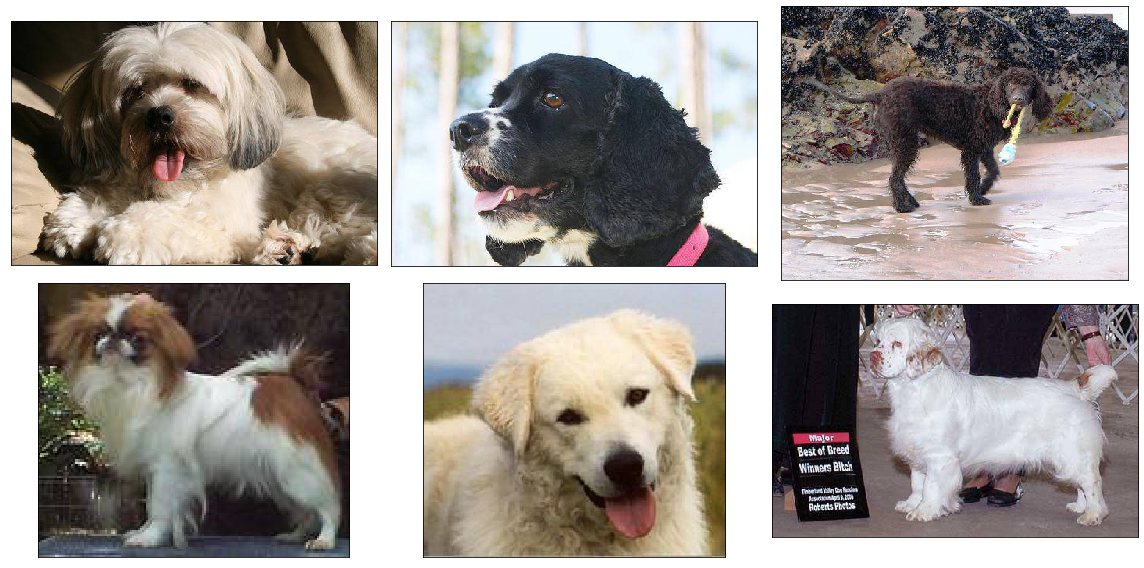

In [2]:
# Images chosen randomly from training folder
ShowImages_from_folder('Dogbreed/train')

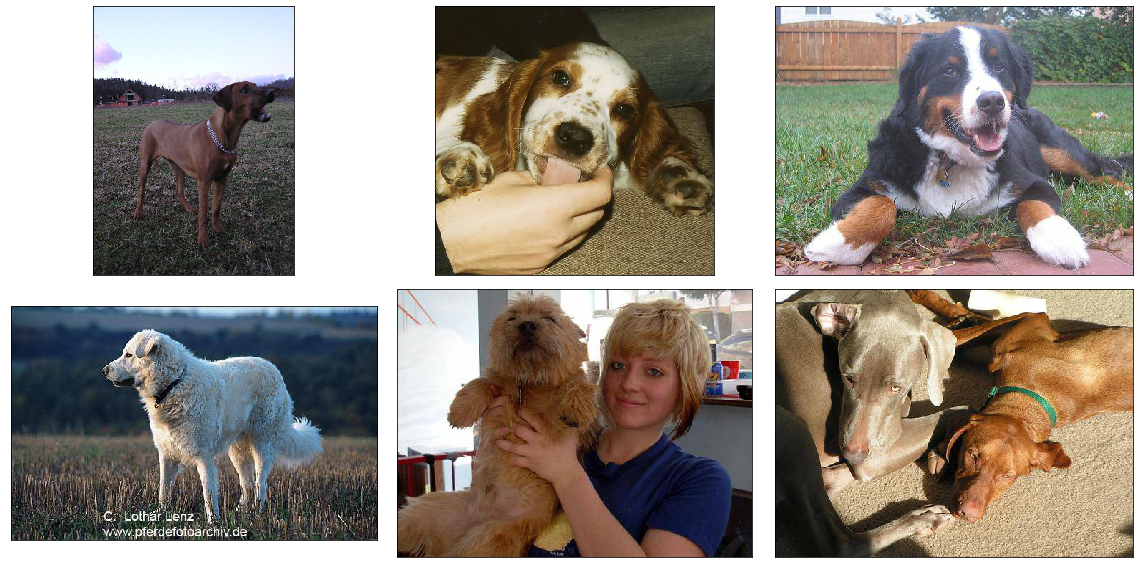

In [3]:
# Images chosen randomly from test folder
ShowImages_from_folder('Dogbreed/test')

Now let's look at some basic properties of the dataset.

,category,count
0,scottish_deerhound,126
1,maltese_dog,117
2,afghan_hound,116
3,entlebucher,115
4,bernese_mountain_dog,114
5,shih-tzu,112
6,great_pyrenees,111
7,pomeranian,111
8,basenji,110
9,samoyed,109


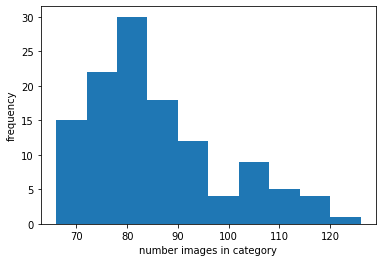

In [4]:
# Number of images of each breed
get_cat_counts('Dogbreed/labels.csv')

In [5]:
# red,green,blue means and stds (per pixel)
train_means, train_stds = get_stats('Dogbreed/train')
test_means, test_stds = get_stats('Dogbreed/test')

print('imagnet_means =',imagenet_stats[0], 'imagnet_stds =', imagenet_stats[1])
print('train_means =',np.round(train_means,3), 'train_stds =', np.round(train_stds,3))
print('test_means =',np.round(test_means,3), 'test_stds =', np.round(test_stds,3))


imagnet_means = [0.485 0.456 0.406] imagnet_stds = [0.229 0.224 0.225]
train_means = [0.476 0.452 0.392] train_stds = [0.266 0.261 0.265]
test_means = [0.476 0.451 0.391] test_stds = [0.265 0.259 0.263]


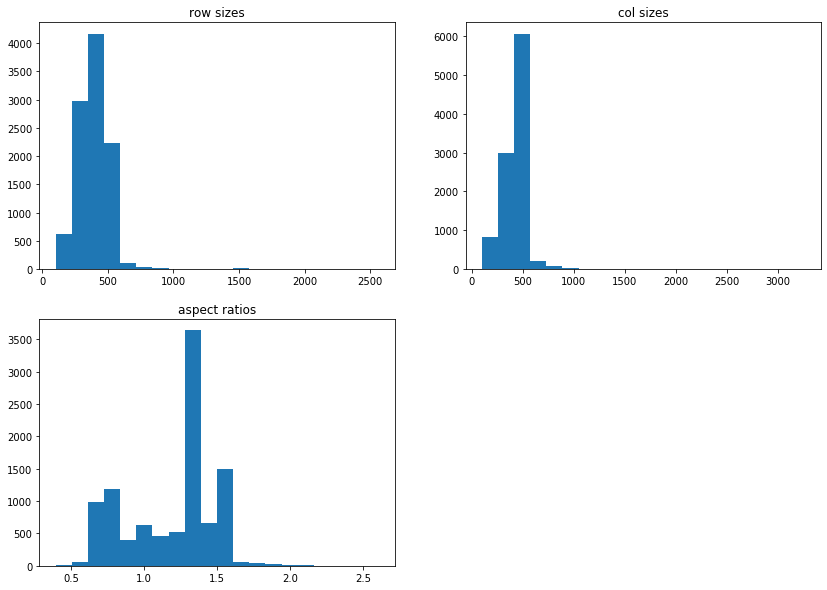

In [6]:
# Histograms of img shapes for train data
plot_imgsize_histograms('Dogbreed/train',num_bins=20)

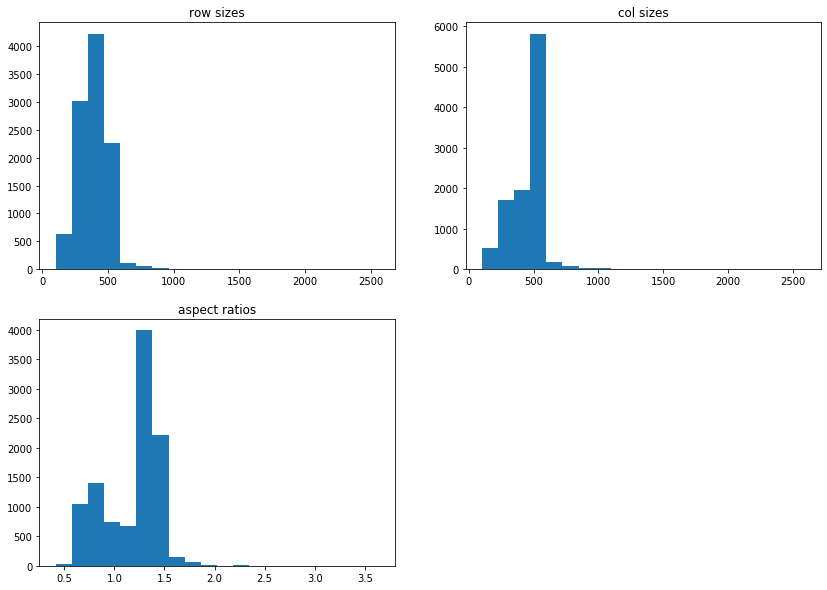

In [7]:
# Histograms of image shapes for test data
plot_imgsize_histograms('Dogbreed/test',num_bins=20)

Observations: 
1. Training Data is relatively balanced (between 126 to 66 images for each dogbreed).
1. Red/Green/Blue means and stds of images are fairly close to imagenet. 
2. Images are of 'normal size', mostly between 100-700 pixels in width and height.
3. Image aspect ratios are not very large, mostly in range [0.5,2]

So, like the DogsCats example, this is again a pretty standard image classification dataset. However, because there are many more classes and some of them are very similar looking (e.g. 'siberian_husky' and 'eskimo_dog'), it is a more difficult classification problem. Thus, we will train with a few different more advanced architectures, and then ensemble the results.

### Training 

#### General Training Strategy

We will ensemble predictions from 2 differenent architectures: senet154 and nasnetalarge. 

For both models, we will leave the backbone frozen throughout the training process. I did some other experiments, but did not find any significant improvment from unfreezing and training all layers together with differential learning rates for this dataset. 

This may sometimes be the case if the underlying images are very similar to the things seen in ImageNet, and there are a large number of possible classes for classification (i.e. 120 different dogbreeds). In this case, the pretrained ImageNet weights for the backbone do a good job of extracting the right sort of spatial features of the images to use for classification. And trying to retrain these weights on a dataset with many classes, and far fewer images than ImageNet, may easily lead to overfitting. Instead, it may be best to simply use the good spatial features coming from the pretrained backbone, and tune the weights in the head component used for classifying from the spatial features. 

** NOTE: In fact, this Kaggle dataset is actually just the Stanford Dogbreed Dataset, split into train and test images by the competion organizers and with the images renamed. And the Stanford Dogbreed Dataset is itself part of Imagnet. So, all the dog images in this Kaggle dataset are actually part of Imagenet, and thus certainly qualify as images 'very similar to things seen in ImageNet'. Nevertheless, because the ImageNet dataset is so large and has 1000 different classes, many of which are for things quite different than dogs, it seems unlikely that the pre-trained architectures have in any sense 'memorized' these particular dog images in their weights. So, I do not believe the lack of improvement from unfreezing the backbones comes primarily from the fact that the data is exact ImageNet photos. Rather, it is simply because the photos are similar enough to ImageNet, but there are far fewer of them and there are still a large number of classes (120 different dog breeds).

#### Senet154

Start training with sz=224 images.

In [8]:
# NOTE: If no val_csv is provided with the ImageDataObj.from_csv method, as below, a 20% random subset
# of the training data is chosen for validation. Same holds for other DataObj constructors if validation 
# data is not explicitly specified.

PATH = 'Dogbreed'
transforms = get_transforms('SideOn',sz=224)
data = ImageDataObj.from_csv(PATH, transforms, bs=64, train_csv='labels.csv', 
                             train_name='train', test_name='test', suffix='.jpg')

In [9]:
arch = vmods.senet154()
model = ImageClassificationNet(data,arch)
learner = ImageLearner(PATH,data,model)

learner.freeze()
learner.bn_freeze()

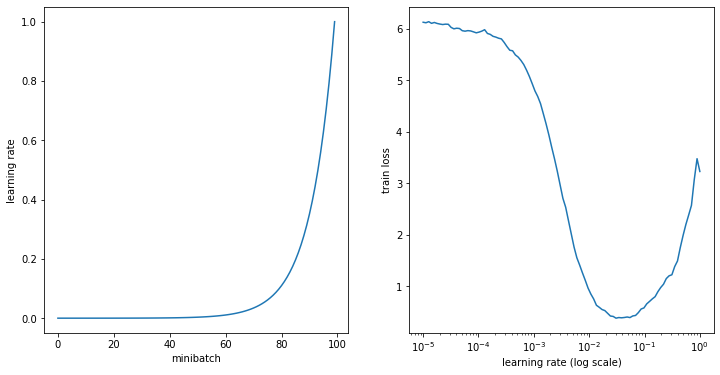

In [10]:
learner.find_lr(length=100)

In [11]:
lr = 0.005
learner.fit(lr,2,save_name='224_Senet',save_method='best')

epoch   train_loss  val_loss    accuracy    

0       0.51406     0.22758     0.93444       epoch run time: 1 min, 46.90 sec
1       0.28120     0.21395     0.93933       epoch run time: 1 min, 46.84 sec


Resize data to sz=299 and continue training (with cycles).

In [12]:
learner.load('224_Senet')
learner.data_resize(299)
learner.fit_cycles(lr,lr/100,num_cycles=2,base_length=2,save_name='299_Senet',save_method='best')

epoch   train_loss  val_loss    accuracy    

0       0.21244     0.18172     0.94521       epoch run time: 3 min, 1.17 sec
1       0.16958     0.17844     0.94472       epoch run time: 3 min, 1.24 sec
2       0.16959     0.17643     0.95010       epoch run time: 3 min, 1.16 sec
3       0.13831     0.17406     0.94667       epoch run time: 3 min, 1.06 sec


Make predictions for val and test set using test time augmentation (TTA).

In [13]:
learner.load('299_Senet')
predprob_val_1, predlabel_val_1 = learner.TTA('val')
predprob_test_1, predlabel_test_1 = learner.TTA('test')

In [14]:
# Validation Loss and Accuracy for TTA
target_val = learner.data.val_ds.y
loss = learner.loss_func(torch.log(TEN(predprob_val_1)),TEN(target_val)).item()
accuracy = skm.accuracy_score(target_val,predlabel_val_1)
print('val_loss:',loss)
print('val_accuracy:',accuracy)

val_loss: 0.16800613701343536
val_accuracy: 0.9530332681017613


#### NasnetaLarge

'alternate_stats': mean=[0.5,0.5,0,5], std=[0.5,0.5,0.5]

The nasneta model is pretrained using sz=331 images (instead of sz=224 like other models).
It is also trained using 'alternate_stats' for normalization in data transforms instead of 
the default 'imagenet_stats'.

Thus, in our training we must switch to the alternate_stats. We will train first for a 
few epochs using sz=331 images (instead of 224), and then switch to sz=399 (instead of 299). 
Training with sz=224 does not give very good results.

In [15]:
arch = vmods.nasnetalarge()
learner.model = ImageClassificationNet(data,arch).cuda()
learner.freeze()
learner.bn_freeze()

learner.switch_transform_stats(alternate_stats)

Start training with sz=331 images.

In [16]:
learner.data_resize(331,bs=32)

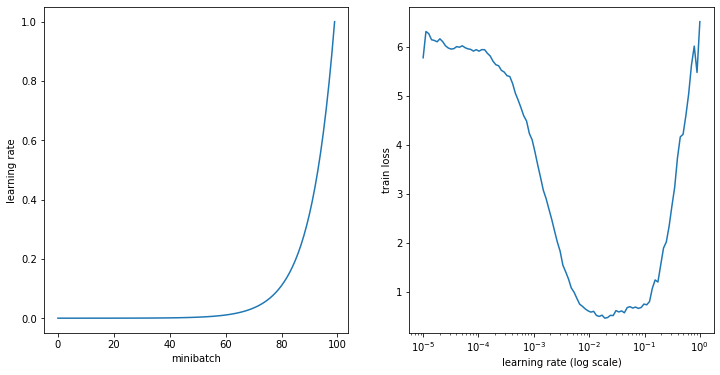

In [17]:
learner.find_lr(length=100)

In [18]:
lr = 0.003
learner.fit(lr,2,save_name='331_Nasnet',save_method='best')

epoch   train_loss  val_loss    accuracy    

0       0.33731     0.21451     0.94325       epoch run time: 3 min, 15.16 sec
1       0.23811     0.19647     0.94423       epoch run time: 3 min, 15.03 sec


Resize data to sz=399 and continue training (with cycles).

In [19]:
learner.load('331_Nasnet')
learner.data_resize(399)
learner.fit_cycles(lr,lr/100,num_cycles=2,base_length=2,save_name='399_Nasnet',save_method='best')

epoch   train_loss  val_loss    accuracy    

0       0.16505     0.17066     0.95205       epoch run time: 4 min, 40.96 sec
1       0.11128     0.17326     0.95010       epoch run time: 4 min, 40.58 sec
2       0.14411     0.18263     0.94716       epoch run time: 4 min, 40.25 sec
3       0.11841     0.17234     0.95254       epoch run time: 4 min, 40.24 sec


Make predictions for val and test set using test time augmentation (TTA).

In [20]:
learner.load('399_Nasnet')
predprob_val_2, predlabel_val_2 = learner.TTA('val')
predprob_test_2, predlabel_test_2 = learner.TTA('test')

In [21]:
# Validation Loss and Accuracy for TTA
loss = learner.loss_func(torch.log(TEN(predprob_val_2)),TEN(target_val)).item()
accuracy = skm.accuracy_score(target_val,predlabel_val_2)
print('val_loss:',loss)
print('val_accuracy:',accuracy)

val_loss: 0.1658753603696823
val_accuracy: 0.9540117416829745


#### Average Predictions from Models

In [22]:
predprob_val = (predprob_val_1 + predprob_val_2)/2
predlabel_val = np.argmax(predprob_val,axis=1)

predprob_test = (predprob_test_1 + predprob_test_2)/2
predlabel_test = np.argmax(predprob_test,axis=1)

In [23]:
# Validation Loss and Accuracy for Ensemble
loss = learner.loss_func(torch.log(TEN(predprob_val)),TEN(target_val)).item()
accuracy = skm.accuracy_score(target_val,predlabel_val)
print('val_loss:',loss)
print('val_accuracy:',accuracy)

val_loss: 0.13836261630058289
val_accuracy: 0.9598825831702544


#### Make Kaggle Submission

In [24]:
IDs = os.listdir('Dogbreed/test')
IDs = [ID[:-4] for ID in IDs] # remove .jpg extension from image names
categories = [data.categories[i] for i in range(len(data.categories))]

submission_IDs = pd.DataFrame({'id':IDs})
submission_preds = pd.DataFrame(predprob_test,columns=categories)
submission_df = submission_IDs.join(submission_preds)
submission_df.to_csv('Dogbreed/submission.csv',index=False)

In [25]:
submission = pd.read_csv('Dogbreed/submission.csv')
submission

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,de084b830010b6107215fef5d4a75b94,9.258579e-06,6.578830e-06,1.665851e-04,1.072403e-05,5.825374e-06,3.600576e-06,6.479701e-06,1.633458e-06,7.234142e-06,...,1.178753e-06,9.932405e-07,9.159080e-06,9.757950e-07,1.017271e-05,1.120213e-05,1.292995e-05,6.949175e-05,1.259451e-05,4.513642e-06
1,6b423ca7020e70eb05732843c5d2bad1,1.240381e-05,2.489447e-05,3.562761e-06,4.354013e-06,9.117479e-06,9.042935e-06,1.551026e-05,1.418718e-05,7.534943e-05,...,5.214468e-06,1.662608e-06,2.559281e-05,6.924637e-06,3.476106e-06,8.267298e-06,6.116601e-05,5.506754e-06,2.878305e-05,3.049548e-06
2,74aa7e201e0e93e13e87b986a7d31839,1.068681e-06,1.652984e-06,4.875312e-06,8.972145e-05,2.269922e-06,1.608094e-06,4.945235e-07,4.346557e-07,3.795626e-07,...,1.401712e-06,6.210291e-07,1.636870e-07,1.595423e-06,4.225842e-07,4.114483e-06,8.190058e-07,4.062430e-06,2.387660e-02,3.534925e-07
3,a079f72193264bc5685e5d28d7372680,8.219699e-04,3.921775e-05,1.334208e-05,7.525025e-05,3.265298e-06,3.123709e-06,1.761117e-04,1.684813e-05,1.234502e-05,...,3.799342e-05,2.116588e-05,3.543760e-05,4.218084e-06,4.293633e-05,1.637194e-05,6.524501e-05,3.523927e-05,6.362067e-05,3.922610e-05
4,583f7580fa5fec1266331fcf83b76fd6,1.322688e-05,7.266080e-06,8.064094e-07,3.338333e-06,3.351292e-07,2.682266e-06,2.892551e-06,6.108298e-07,3.245254e-07,...,2.055964e-06,5.973985e-08,3.962837e-07,1.896774e-06,4.273498e-07,7.237672e-07,6.873768e-07,2.637856e-05,1.596738e-04,2.792693e-07
5,72cd7496a319c832f670fbb8d349217e,1.237735e-06,7.256885e-08,4.412219e-07,9.474850e-07,1.946390e-06,2.993011e-08,2.266494e-07,1.459952e-07,4.767558e-07,...,1.948642e-07,1.457945e-07,3.142233e-05,4.174280e-07,6.334607e-06,3.240915e-07,1.479593e-07,3.812400e-08,1.385441e-07,4.974398e-08
6,ed9e75a553dbb4712addc1638693dc03,6.799110e-07,4.321007e-06,5.808818e-07,5.584507e-06,2.148489e-06,3.998678e-06,1.548555e-06,9.821326e-07,4.103123e-06,...,3.810684e-07,2.272376e-06,3.714968e-06,1.520254e-07,2.593030e-06,2.916353e-06,1.787683e-06,3.697404e-07,2.084456e-07,1.371879e-06
7,6322fa7edb40af844609b4843a89b5fd,3.070407e-07,1.073246e-06,9.107144e-07,5.187887e-07,2.562777e-06,1.191131e-06,8.530781e-08,8.611362e-07,1.317895e-07,...,3.480753e-07,7.795322e-07,9.996599e-01,9.479505e-07,2.871633e-06,4.368872e-07,1.991825e-06,4.501808e-08,6.083976e-08,7.299007e-07
8,d18de4f66f7d2ae8dffb08ec13b9bbc5,1.893156e-06,9.823524e-06,1.039249e-05,2.999396e-06,1.699510e-06,2.520372e-06,1.201783e-05,1.245090e-06,5.349869e-06,...,2.076642e-06,1.302072e-06,3.135967e-07,7.569111e-06,9.765126e-06,4.295791e-06,2.448094e-06,1.779791e-06,4.123764e-06,7.508122e-06
9,8c567325012bf8d7daeff453ec959312,1.183212e-06,2.705082e-06,1.133251e-06,1.408459e-06,1.690367e-05,8.113447e-03,6.298753e-06,8.881325e-06,5.506635e-06,...,1.290944e-06,2.516388e-06,1.347829e-06,2.317299e-05,8.817946e-06,6.032782e-06,3.684094e-06,2.013507e-05,8.777702e-07,6.420806e-06


This was a Kaggle Playground Competition, so there are no private leaderboard scores, only public scores. 

My submission received a Kaggle public leaderboard score of 0.14594 (for same log loss metric used in training). 
This would have been 165th place out of 1283 teams on public leaderboard. 

However, the scores for at least the first 120 places, which were all VERY LOW below 0.03, are most likely artificial. This was just a playground competition, and as noted above the images were all from the Stanford Dogbreed Dataset, where the labels for all images are known. So, it was possible to train a model on the full labeled Stanford Dogbreed Dataset, which contains both the Kaggle train dataset and Kaggle test dataset. Training like this with the test data in your train set obviously allows you to achieve much better (almost perfect) accuracy, if you train long enough, because you are grossly overfitting. 

One team posted explicitly in the forums that they had done this and achieved a very low score of 0.01, by ensembling several models trained on the full Stanford Dogbreed Dataset. Then, in the comments to that discussion, it seems many other teams were later doing the same thing. See https://www.kaggle.com/c/dog-breed-identification/discussion/40779#latest-445409